In [3]:
import os, sys, json, copy, random
import pandas as pd
import numpy as np
from fastai.vision import *
from fastai.utils.mem import  gpu_mem_get_free_no_cache
gpu_mem_get_free_no_cache()

0

In [4]:
#cloud
data_dir = Path('data/alphapilot/')

zip_fn = data_dir/'Data_Training.zip'
raw_fn = data_dir/'data_training'
label_fn = data_dir/'truth_new.json'

#local
if os.name == 'nt':
    
    data_dir = Path('../../../../alphapilot/')
    
    #from os.getcwd() == files/fastai/course-v3/nbs/custom
    zip_fn = data_dir/'Data_Training.zip'
    raw_fn = data_dir/'Data_Training/Data_Training/'
    label_fn = data_dir/'truth_new.json'

In [5]:
with open(label_fn, 'r') as f:
    truth = json.load(f)

print('truth:', *list(truth.items())[:2], sep='\n')

list_blanks = [k for k,v in truth.items()
                 if len(v[0]) == 0]

print('\nall blank images: ', list_blanks)

truth_1dim = {k:v[0] for k,v in truth.items() 
                      if k not in list_blanks
             }

print('\ntruth_1dim:', *list(truth_1dim.items())[:2], sep='\n')

print( '\ndifference in length: '
       ,len(list(truth.items())) 
       ,len(list(truth_1dim.items()))
     )

truth_df = pd.DataFrame(truth_1dim)

truth:
('IMG_9622.JPG', [[583, 439, 772, 431, 779, 628, 582, 631]])
('IMG_9925.JPG', [[481, 295, 769, 268, 777, 590, 480, 589]])

all blank images:  ['IMG_1343.JPG', 'IMG_0688.JPG', 'IMG_6608.JPG', 'IMG_0492.JPG']

truth_1dim:
('IMG_9622.JPG', [583, 439, 772, 431, 779, 628, 582, 631])
('IMG_9925.JPG', [481, 295, 769, 268, 777, 590, 480, 589])

difference in length:  5831 5827


In [6]:
gate_data = PointsItemList.from_folder(raw_fn)

TRUTH_INDS  = list(truth_df.columns)
def filter_img_by_truth(fn):
    return fn.name in TRUTH_INDS

filter_records = filter_img_by_truth

len0 = len(gate_data)

gate_data.filter_by_func(filter_records)

len1 = len(gate_data)

print('dataset reduced from len: %i to len: %i' % (len0, len1))

np.random.seed(42)
#set torch variable here or what?

gate_data = gate_data.split_by_rand_pct(valid_pct=0.2)

print('num records in train: %i ; and in validation: %i' 
      % (len(gate_data.train.items), len(gate_data.valid.items)))

def label_points(fn):
    '''
        input:  x0,y0,...x3,y3 (list)
        output: [y0,x0],...[y3,x3] (list) 
         
        >use y_first=True in label-load-func
    '''
    p = truth_df[fn.name]
    return tensor([ [ float(p[i*2+1]), float(p[i*2+0]) ] for i in range(4)])

gate_data = gate_data.label_from_func(label_points, )

dataset reduced from len: 9339 to len: 5827
num records in train: 4662 ; and in validation: 1165


IMG_0006.JPG
tensor([[210., 307.],
        [238., 609.],
        [527., 610.],
        [533., 305.]])


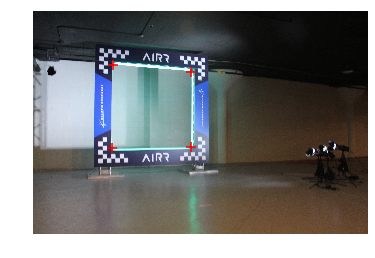

In [7]:
i = 1

fn =  gate_data.train.x.items[i]
img = gate_data.train.x.get(i)
pts = gate_data.train.y.items[i]

def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

print(fn.name)
print(pts)
img.show(y=get_ip(img, pts), figsize=(6, 6), c='r', marker='+', s=100, hide_axis=False)

In [8]:
img0 = gate_data.train.x.get(0)
img0.shape

def mod_img_divisor(h,w):
    return [ i for i in range(2, min(h,w) // 2) 
               if (h % i ==0) and (w % i ==0 )
           ]
divisors = mod_img_divisor(*list(img0.shape)[1:])

[tensor(img0.shape[1:]) / e for e in divisors]

gate_data = gate_data.transform(get_transforms()
                                ,tfm_y=True
                                ,size=(108,162)
                                ,remove_out=False
                               )    

batch_size = 4

gate_bunch = gate_data.databunch(bs=batch_size, num_workers=0 )

assert isinstance(gate_bunch, ImageDataBunch)

data_final = gate_bunch.normalize(imagenet_stats)

In [9]:
learn = cnn_learner(data_final, models.resnet34)

In [30]:
learn.path, learn.model_dir

(WindowsPath('../../../../alphapilot/Data_Training/Data_Training'), 'models')

In [35]:
_ = learn.load('ap-3-cpu')

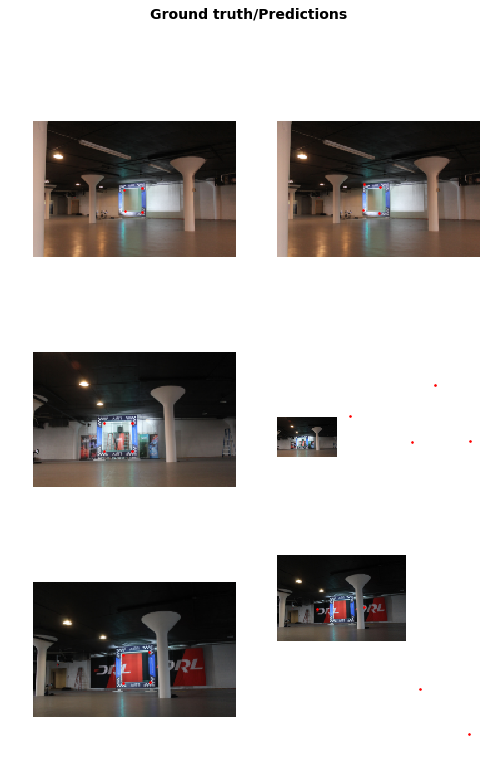

In [55]:
learn.show_results(rows=3)

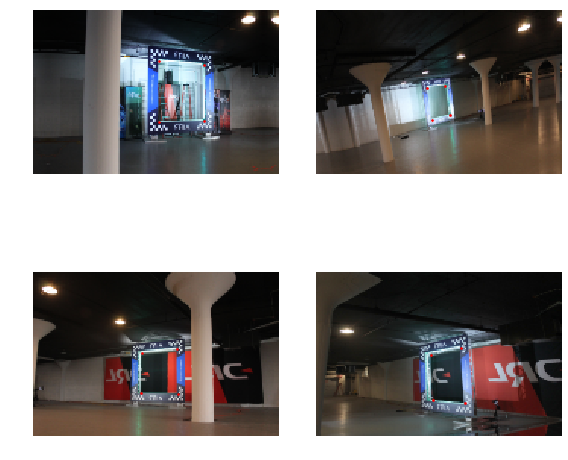

In [56]:
data_final.show_batch(3)

##### Train

In [15]:
lr = 2e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.076389,0.098097,01:00
1,0.100183,35.011089,00:59
2,0.058401,16.320200,01:00
3,0.040182,1.061113,00:59
4,0.036428,0.824659,01:00


##### Import / Export

In [17]:
# export as pkl
defaults.device = torch.device('cpu')

export_fn = Path(os.getcwd())
export_fn = export_fn/'old-models'/'ap-1-cpu.pkl'

learn.export(export_fn)

In [10]:
import_fn = Path(os.getcwd())
import_fn = import_fn/'old-models'

pathlike_fn = import_fn/'ap-1-cpu.pkl'

# load pkl
learn2 = load_learner(path='', fname=pathlike_fn)

##### Graphical Display

In [137]:
# helper functions for working with 

def scaled_pts(pts):
    ''' use a helper function to convert coords flow->absolute
        input  pts - an ImagePoints object
        output tensor(4,2)
    '''
    return scale_flow(
                FlowField(pts.size, pts.data)
                            ,to_unit=False
                        ).flow.flip(1)

def scaled_pts_2(data_slice, item_num):
    ''' use a secondary pattern to convert coords flow->absolute:
        input data_slice=data_final.valid_dl
              item_num=0
        output tensor(4,2)
    '''
    pll = PointsLabelList([])
    re_pts = pll.reconstruct( data_slice.y.items[item_num]
                             ,data_slice.x.get(item_num))
    return re_pts.data

def get_ip(img,pts): 
    ''' converts plain tensor representing points to an 
        ImagePoints obj; useful for inserting into show(y=?)
    '''
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

def clean_preds(pred_pts):
    '''remove out-of-bounds from coords'''
    pass

200 IMG_8806.JPG
tensor([[ 111.,  594.],
        [ 202., 1004.],
        [ 697., 1007.],
        [ 755.,  592.]])
----
tensor([[78.0546, 29.1903],
        [92.4405, 28.9957],
        [92.4121, 83.5083],
        [78.2821, 83.9489]])


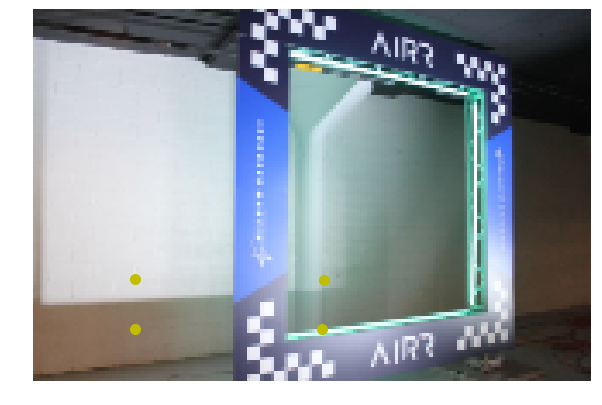

In [140]:
i = 200
# i = np.random.randint(0, len(data_final.valid_dl.x.items) - 1)

fn =  data_final.valid_dl.x.items[i]
img = data_final.valid_dl.x.get(i)
truth_pts = data_final.valid_dl.y.items[i]

pred_pts = learn2.predict(img)  #outputs tuple(ImgPts obj, data)
scaled_pred_pts = scaled_pts(pred_pts[0])

img2 = img.clone()
img2.resize(size=(3,108,162))

print(i, fn.name); print(truth_pts); print('----')
print(scaled_pred_pts) #TODO - put on same terms as ground-truth, round

img2.show( 
          # y=get_ip(img, truth_pts)
          y=get_ip(img, scaled_pred_pts)
         ,figsize=(10, 10)
         ,c='y' ,marker='o', s=100
        )